# Reconocimiento de Emociones en Habla Utilizando SVM

**Machine Learning**

**Universidad Tecnológica de Pereira**

*Maestría en Ingeniería de Sistemas y Computación*

*Chicue Garcia Lia Natalia*

*2021-2*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import seaborn as sns

import librosa
import librosa.display

from sklearn.svm import SVC 
from sklearn.preprocessing import scale
from sklearn.pipeline import make_pipeline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio
from ipywidgets import  interact, widgets
from scipy.io import wavfile

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

El siguiente proceso de se puede evitar y pasar al preproseamiento de datos.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 58 kB 4.3 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=517bd9937b6b7642504992f850ba73b9c816ab1f374fa1e6e4393d4412448ff8
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-10 18:11:20          15791       1251  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9547        698  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4315        303  1.0              
dhruvildave/wikibooks-dataset

In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en -p /content/sample_data --unzip

100% 986M/987M [00:24<00:00, 36.4MB/s]
100% 987M/987M [00:24<00:00, 42.1MB/s]


In [ ]:
#Almacenamos los datos de cada carpeta 
Crema = "/content/sample_data/Crema"
Ravdess = "/content/sample_data/Ravdess/audio_speech_actors_01-24"
Savee = "/content/sample_data/Savee"
Tess = "/content/sample_data/Tess"

## Adquisición de Bases de Datos

### Dataset Crema

In [ ]:
#Para Crema
emotion_df = []

for wav in os.listdir(Crema):
    info = wav.partition(".wav")[0].split("_")
    if info[2] == 'SAD':
        emotion_df.append(("sad", Crema + "/" + wav))
    elif info[2] == 'ANG':
        emotion_df.append(("angry", Crema + "/" + wav))
    elif info[2] == 'DIS':
        emotion_df.append(("disgust", Crema + "/" + wav))
    elif info[2] == 'FEA':
        emotion_df.append(("fear", Crema + "/" + wav))
    elif info[2] == 'HAP':
        emotion_df.append(("happy", Crema + "/" + wav))
    elif info[2] == 'NEU':
        emotion_df.append(("neutral", Crema + "/" + wav))
    else:
        emotion_df.append(("unknown", Crema + "/" + wav))

dfCrema = pd.DataFrame.from_dict(emotion_df)
dfCrema.rename(columns={1 : "Path", 0 : "Emocion"}, inplace=True)
dfCrema.fillna(0)

dfCrema.head()

,Emocion,Path
0,fear,/content/sample_data/Crema/1037_IOM_FEA_XX.wav
1,sad,/content/sample_data/Crema/1089_IEO_SAD_HI.wav
2,sad,/content/sample_data/Crema/1017_IWL_SAD_XX.wav
3,disgust,/content/sample_data/Crema/1090_IWL_DIS_XX.wav
4,disgust,/content/sample_data/Crema/1037_MTI_DIS_XX.wav


### Dataset Ravdess

In [ ]:
emotion_df = []
ravdess_directory_list = os.listdir(Ravdess)

for dir in ravdess_directory_list:
    actor = os.listdir(os.path.join(Ravdess, dir))
    for wav in actor:
        info = wav.partition(".wav")[0].split("-")
        emotion = int(info[2])
        emotion_df.append((emotion, os.path.join(Ravdess, dir, wav)))

dfRavdess = pd.DataFrame.from_dict(emotion_df)
dfRavdess.rename(columns={1 : "Path", 0 : "Emocion"}, inplace=True)
dfRavdess.Emocion.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
dfRavdess.fillna(0)
dfRavdess.head()

,Emocion,Path
0,happy,/content/sample_data/Ravdess/audio_speech_acto...
1,fear,/content/sample_data/Ravdess/audio_speech_acto...
2,happy,/content/sample_data/Ravdess/audio_speech_acto...
3,sad,/content/sample_data/Ravdess/audio_speech_acto...
4,fear,/content/sample_data/Ravdess/audio_speech_acto...


### Dataset Savee

In [ ]:
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    else:
        file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emocion'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
dfSavee = pd.concat([emotion_df, path_df], axis=1)

dfSavee.fillna(0)
dfSavee.head()

,Emocion,Path
0,disgust,/content/sample_data/SaveeKL_d03.wav
1,happy,/content/sample_data/SaveeKL_h04.wav
2,neutral,/content/sample_data/SaveeKL_n10.wav
3,happy,/content/sample_data/SaveeJE_h10.wav
4,angry,/content/sample_data/SaveeDC_a08.wav


### Dataset Tess

In [ ]:
tess_directory_list = os.listdir(Tess)

emotion_df = []

for dir in tess_directory_list:
    for wav in os.listdir(os.path.join(Tess, dir)):
        info = wav.partition(".wav")[0].split("_")
        emo = info[2]
        if emo == "ps":
            emotion_df.append(("surprise", os.path.join(Tess, dir, wav)))
        else:
            emotion_df.append((emo, os.path.join(Tess, dir, wav)))


dfTess = pd.DataFrame.from_dict(emotion_df)
dfTess.rename(columns={1 : "Path", 0 : "Emocion"}, inplace=True)
dfTess.fillna(0)
dfTess.head()

,Emocion,Path
0,surprise,/content/sample_data/Tess/OAF_Pleasant_surpris...
1,surprise,/content/sample_data/Tess/OAF_Pleasant_surpris...
2,surprise,/content/sample_data/Tess/OAF_Pleasant_surpris...
3,surprise,/content/sample_data/Tess/OAF_Pleasant_surpris...
4,surprise,/content/sample_data/Tess/OAF_Pleasant_surpris...


### Concatenamos los dataset

In [ ]:
dfSpeech = pd.concat([dfRavdess,dfSavee,dfCrema,dfTess], axis = 0) 
dfSpeech.fillna(0)
dfSpeech.head()

,Emocion,Path
0,happy,/content/sample_data/Ravdess/audio_speech_acto...
1,fear,/content/sample_data/Ravdess/audio_speech_acto...
2,happy,/content/sample_data/Ravdess/audio_speech_acto...
3,sad,/content/sample_data/Ravdess/audio_speech_acto...
4,fear,/content/sample_data/Ravdess/audio_speech_acto...


In [ ]:
from pathlib import Path

dfSpeech.to_csv("dfSpeech.csv",index=False)
output_file = 'dfSpeech.csv'
output_dir = Path('/content/sample_data') 

output_dir.mkdir(parents=True, exist_ok=True)

dfSpeech.to_csv(output_dir / output_file) 

##Visualizacion

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


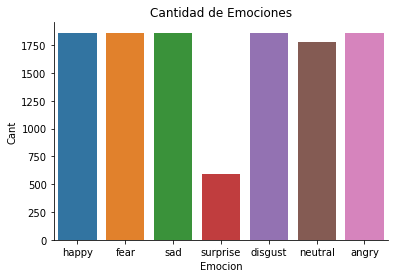

In [ ]:
plt.title('Cantidad de Emociones')
sns.countplot(dfSpeech.Emocion)
plt.ylabel('Cant')
plt.xlabel('Emocion')
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [ ]:
#Onda
def waveplot(data,freq_muestreo,emocion):
  plt.figure(figsize=(10,3))
  plt.title('Diagrama de Onda para {} '.format(emocion), size=15)
  librosa.display.waveplot(data, sr=freq_muestreo)
  plt.show()

#Espetrograma
def espectrograma(data,freq_muestreo,emocion):
  X = librosa.stft(data)
  X2db = librosa.amplitude_to_db(abs(X))
  plt.figure(figsize=(12,3))
  plt.title('Espectrograma para {}'.format(emocion), size=15)
  librosa.display.specshow(X2db, sr=freq_muestreo, x_axis='time', y_axis='hz')

In [ ]:
@interact(emocion = ['angry', 'happy', 'fear', 'sad', 'neutral', 'disgust', 'surprise'], M = [1,5,8,13])
def experimentBC(emocion, M):
  path = np.array(dfSpeech.Path[dfSpeech.Emocion==emocion])[1]
  print('Se esta viendo el archivo:\n', path)
  Audio(path)

  data, sampling_rate = librosa.load(path)
  waveplot(data, sampling_rate, emocion)
  espectrograma(data, sampling_rate, emocion) 

interactive(children=(Dropdown(description='emocion', options=('angry', 'happy', 'fear', 'sad', 'neutral', 'di…

## Preprocesamiento de Datos

### Extracción de Características

Para el presente estudio se extraerán las siguientes características de cada Base de Datos

1. **Energía** = Es la suma de cuadrados de los valores de señal, normalizados por la longitud de fotograma respectiva.
```
energia = np.array([np.sum(np.abs(data[i:i+frame_length]**2))
                      for i in range(0,len(data.shape[0]),hop_length)
                     ]) / frame_length
  eng = np.mean(energia, axis=0)
  result=np.hstack((result, eng)) 
```

2. **Vector Chroma** =  Un sonido se puede separar en dos componentes; altura de tono y croma, en la cual se consideran doce valores cromáticos representados por el conjunto {C, C♯, D, D♯, E , F, F♯, G, G♯, A, A♯, B},los cuales se pueden representar a partir de un espectrograma de forma de onda o potencia.
```
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft)) 
```

3. **Espectrograma de Mel**  =  El espectrograma de mel consiste en la representación gráfica del espectro donde las frecuencias se convierten a la escala mel, es decir una escala logarítmica.  

 Para ser más específicos, la escala de mel es una escala musical perceptual de tonos juzgados como intervalos equiespaciados por parte de observadores.

 El punto de referencia entre esta escala y la frecuencia normal se define equiparando un tono de 1000 Hz, 40 dBs por encima del umbral de audición del oyente, con un tono de 1000 mels. Por encima de 500 Hz, los intervalos de frecuencia espaciados exponencialmente son percibidos como si estuvieran espaciados linealmente. En consecuencia, cuatro octavas en la escala de hercios por encima de 500 Hz se comprimen a alrededor de dos octavas en la escala mel. El nombre mel viene de la palabra melodía para indicar que se basa en la percepción humana de los tonos.
```
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))
```


4. **Coeﬁcientes Cepstrales en las Frecuencias de Mel** =  Son valores para la representación del habla basados en la percepción auditiva humana. Los MFCC muestran las características locales de la señal de voz asociadas al tracto vocal (dependiendo del instante de análisis), según el modelo filtro-fuente. Estos coeficientes se derivan de la transformada de Fourier, pero la particularidad básica es que en MFCC las bandas de frecuencia están situadas logarítmicamente.
```
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))
```

5. **Raíz del error cuadrático medio** =  Calcula el valor de Raíz del error cuadrático medio (RMS) para cada fragmento de sonido o fotograma. 
```
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))
```

6. **Velocidad de cruce cero** =  Es la velocidad a la que una señal cambia de positiva a cero a negativa o de negativa a cero a positiva.
```
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result=np.hstack((result, zcr))
```

7. **Centroide Espectral** =  Es un tipo de característica estadística que aporta información acerca de la forma del espectro, concretamente define el centro de gravedad del espectro, es decir, considera el espectro como una distribución de probabilidad, la cual viene determinada por la amplitud del espectro para cada frecuencia, obteniendo así la frecuencia media ponderada en amplitud.
```
  cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T,axis=0)
  result = np.hstack((result, cent))
```

8. **Ancho de Banda Espectral** = Se refiere a la longitud, medida en hercios (Hz), de la extensión de frecuencias en la que se concentra la mayor potencia de la señal.
```
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, spec_bw))
```

9. **Contraste Espectral** =  Cada frame de un espectrograma S se divide en sub-bandas. Para cada sub-banda, el contraste de energía se estima comparando la energía media en el en el pico (energía pico) con la del pico inferior (energía valle). Los valores de alto contraste generalmente corresponden a señales claras de banda estrecha, mientras que los valores de bajo contraste corresponden al ruido de banda ancha.
```
  S_c = np.abs(librosa.stft(data))
  contrast = np.mean(librosa.feature.spectral_contrast(S=S_c, sr=sample_rate).T, axis=0)
  result = np.hstack((result, contrast))
```
10. **Coeficiente de Tonalidad o Planitud Espectral** = La planitud espectral se mide típicamente en decibelios y proporciona una forma de cuantificar qué tan parecido al tono es un sonido, en lugar de ser parecido al ruido.
```
  flatness = np.mean(librosa.feature.spectral_flatness(y=data).T, axis=0)
  result = np.hstack((result, flatness))
```

11. **Frecuencia Espectral Roll off o Desplazamiento** = Se define para cada segmento de muestra como la frecuencia central de la pendiente de una función de transferencia. Denota los límites (agudos) bajos y altos en una curva de respuesta de frecuencia. 
```
  rolloff=np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T,axis=0)
  result = np.hstack((result, rolloff))
```

12. **Tonnez** =  Como se enuncio en el vector croma, cada sonido puede consistir de 12 clases de tono, este fenómeno considera que el archivo de audio es de 6 clases de tono fusionando algunas de las clases juntas, por lo que el cromagrama clasifica los tonos solo en 6 clases, esto se llama Tonnetz
```
  y1 = librosa.effects.harmonic(data)
  tonnetz = np.mean(librosa.feature.tonnetz(y=y1, sr=sample_rate).T,axis=0)
  result = np.hstack((result, tonnetz))
```




Los valores de `frame_length` y  `hop_length`, dependen de los Coeﬁcientes Cepstrales en las Frecuencias de Mel (MFCC). 

Para calcular los MFCC, se utiliza la transformada rápida de Fourier (FFT), la cual requiere un número de muestras o ventana específico. Este valor se encuentra implícito en la documentación de [librosa para mfcc](https://github.com/librosa/librosa/blob/main/librosa/feature/spectral.py#L1420), específicamente:

* Longitud de la ventana (FFT): 2048 
* Número de muestras: 512

Dado que la frecuencia de muestreo predeterminada para librosa es 22050, la longitud del audio es de 48 s y la ventana es igual a 512, la Longitud de la ventana para los MFCC es:
\begin{align}
nMFCC = \frac{long. audio * n.muestras}{long. ventana}
\end{align}

\begin{align}
nMFCC =  \frac{48 * 22050}{512}\approx 2067
\end{align}

In [ ]:
def extract_features(path):
  hop_length = 512
  frame_length = 2048
  sample_rate = []
  data = []
  result = np.array([])
  data, sample_rate = librosa.load(path)
  
  #Energia
  energia = np.array([
                      np.sum(np.abs(data[i:i+frame_length]**2))
                      for i in range(0,len(data),hop_length)
                     ]) / frame_length
  eng = np.mean(energia, axis=0)
  result=np.hstack((result, eng))

  #Chroma_stft
  stft = np.abs(librosa.stft(data))
  chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
  result = np.hstack((result, chroma_stft)) 

  # MelEspectrograma
  mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mel))
  
  # MFCC
  mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, mfcc))

  # RMS
  rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
  result = np.hstack((result, rms))

  # ZCR
  zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
  result=np.hstack((result, zcr))

  #Centroide Espectral
  cent = np.mean(librosa.feature.spectral_centroid(y=data, sr=sample_rate).T,axis=0)
  result = np.hstack((result, cent))

  #Ancho de Banda Espectral(verificar)
  spec_bw = np.mean(librosa.feature.spectral_bandwidth(y=data, sr=sample_rate).T, axis=0)
  result = np.hstack((result, spec_bw))

  #Contraste Espectral
  S_c = np.abs(librosa.stft(data))
  contrast = np.mean(librosa.feature.spectral_contrast(S=S_c, sr=sample_rate).T, axis=0)
  result = np.hstack((result, contrast))

  #Coeficiente de Tonalidad o Planitud Espectral
  flatness = np.mean(librosa.feature.spectral_flatness(y=data).T, axis=0)
  result = np.hstack((result, flatness))

  # Espectral Rolloff
  rolloff=np.mean(librosa.feature.spectral_rolloff(y=data, sr=sample_rate).T,axis=0)
  result = np.hstack((result, rolloff))

  #Tonnez
  y1 = librosa.effects.harmonic(data)
  tonnetz = np.mean(librosa.feature.tonnetz(y=y1, sr=sample_rate).T,axis=0)
  result = np.hstack((result, tonnetz))

  return result

Extraemos las caracteristicas y las almacenamos en variables. X son las caracteristicas y Y son las emociones.

Sin embargo, este paso se puede obviar pues, con el fin de optimizar el presente articulo, se guardo la base de datos de caracteristicas en el drive. 

In [ ]:
X, Y = [], []
for path, emociones in zip(dfSpeech.Path,dfSpeech.Emocion): #(dfSpeech.Path, dfSpeech.Emocion):
  a = extract_features(path)
  X.append(a)
  Y.append(emociones)

In [ ]:
print(len(X), len(Y)) 

11682 11682


Creamos la base de datos de características

In [ ]:
dfCaracteristicas = pd.DataFrame(X)
dfCaracteristicas["Etiquetas"] = Y
dfCaracteristicas.to_csv("dfCaracteristicas.csv", index=False)
dfCaracteristicas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,Etiquetas
0,0.000858,0.650287,0.712914,0.680495,0.720966,0.743584,0.719803,0.645414,0.652021,0.698253,0.698547,0.705813,0.658126,0.036007,0.001226,0.000758,0.002168,0.006059,0.140541,0.589269,1.007314,1.231389,1.166050,1.501902,4.481015,3.241052,0.408235,0.099400,0.146372,0.249640,0.314392,0.401274,0.406523,1.017191,1.104030,0.803962,0.973843,0.978722,1.425509,0.653898,...,-485.722717,39.168732,-6.152654,5.325203,-0.984410,5.607264,-5.095520,-8.599338,-7.667841,0.390722,-1.317606,-5.994044,0.629980,-3.348660,-3.388866,0.019866,-8.928276,-0.067163,-4.081512,-1.895478,0.018054,0.155549,2434.028001,2415.994328,20.727464,16.148379,17.103892,15.844429,17.495536,16.644827,29.574596,0.036512,4767.397673,-0.063732,-0.033997,-0.093492,0.018629,0.041280,-0.011343,happy
1,0.000520,0.670831,0.706571,0.695164,0.723822,0.739793,0.731415,0.763684,0.776253,0.734800,0.712985,0.675000,0.638577,0.095855,0.000876,0.000987,0.017198,0.304269,1.160462,1.045590,0.311988,0.044958,0.043337,0.147876,0.206550,0.287514,0.351194,0.675542,0.850479,0.417208,0.505695,0.673936,0.368552,0.968475,1.203177,0.610134,0.162525,0.066738,0.086123,0.182480,...,-528.156677,58.459038,-2.905629,10.245566,9.287105,6.497672,3.173160,-5.705697,-7.922248,6.087822,3.446627,-1.805089,5.711708,2.067432,0.523572,5.505246,0.036901,1.912484,-0.922417,2.592987,0.013123,0.093498,2064.250029,2346.209869,23.707138,13.485609,16.083164,15.435057,17.415107,17.749040,30.085764,0.021020,4342.362926,-0.025597,0.023688,-0.032461,-0.008091,0.016744,0.006132,fear
2,0.000099,0.654105,0.649715,0.664405,0.711760,0.710428,0.737249,0.733806,0.721018,0.744153,0.742437,0.668203,0.658224,0.000331,0.000129,0.005201,0.040219,0.098590,0.270299,0.500819,0.270323,0.042700,0.021855,0.014092,0.021089,0.040032,0.075311,0.229292,0.185721,0.039517,0.018331,0.033089,0.036611,0.032331,0.030484,0.159471,0.273865,0.049067,0.020701,0.007797,...,-610.273560,62.114388,5.611975,14.533532,11.167769,8.366303,3.442451,-5.285240,-4.080242,2.878361,-0.752412,-0.872952,3.648935,-0.045889,-0.365390,1.057069,-2.329152,-0.312481,-3.885972,0.734363,0.005598,0.175273,2294.984172,2637.265998,20.269550,13.651860,16.233480,15.788120,17.280170,17.104874,29.328004,0.021118,5246.134277,-0.042455,0.025259,-0.018308,-0.014359,0.035392,0.005600,happy
3,0.000093,0.620108,0.684131,0.660947,0.753979,0.801220,0.689761,0.653901,0.680790,0.701638,0.684307,0.637245,0.596743,0.001798,0.000290,0.006977,0.078592,0.159452,0.240334,0.179252,0.090716,0.069479,0.021787,0.044740,0.082452,0.119948,0.153915,0.031479,0.037988,0.115373,0.104977,0.038926,0.037214,0.085231,0.065196,0.053003,0.149371,0.147096,0.081882,0.010781,...,-608.875671,68.265083,-3.084298,12.418784,11.096520,5.094827,8.741364,-6.107496,-8.176353,5.406942,4.004156,1.163673,5.471842,1.798171,-0.400513,2.008973,1.955521,-0.003635,-1.578520,-0.153080,0.005310,0.178723,2392.965652,2550.237033,19.826788,13.411979,16.304051,16.566369,16.449951,18.235618,28.650613,0.027401,5224.307193,-0.055520,-0.020909,-0.016410,0.002839,0.007088,0.022849,sad
4,0.003056,0.676801,0.652184,0.662590,0.742719,0.836112,0.798138,0.690599,0.723080,0.780454,0.730889,0.713191,0.678046,1.677460,0.016066,0.001278,0.002493,0.062200,0.256111,0.409731,1.363083,1.270031,0.663754,1.115010,3.522688,8.705874,5.853746,2.520057,2.046453,2.371460,2.058430,1.454673,0.424676,0.536317,0.683024,1.312832,2.522955,2.319210,4.989020,3.848015,...,-425.399841,29.277538,-8.870014,6.185245,2.709058,4.995413,-3.385812,-2.042897,-5.905286,0.048969,2.416035,-2.686159,2.218122,2.005703,-1.696017,5.177650,-3.111894,4.719914,2.725621,3.434418,0.032441,0.136451,2365.922727,2368.274296,24.821100,14.265473,15.737777,16.335215,17.357682,16.886478,28.874370,0.051610,4656.425458,-0.03000

### Preparación de Datos

Con el fin de optimizar el presente articulo, se guardo la base de datos de caracteristicas en el drive. Aquí unicamente es necesario cargarla. 

In [ ]:
dfCaracteristicas =pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Final/dfCaracteristicas.csv')
dfCaracteristicas.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,Etiquetas
0,0.000858,0.650287,0.712914,0.680495,0.720966,0.743584,0.719803,0.645414,0.652021,0.698253,0.698547,0.705813,0.658126,0.036007,0.001226,0.000758,0.002168,0.006059,0.140541,0.589269,1.007314,1.231389,1.166050,1.501902,4.481015,3.241052,0.408235,0.099400,0.146372,0.249640,0.314392,0.401274,0.406523,1.017191,1.104030,0.803962,0.973843,0.978722,1.425509,0.653898,...,-485.722717,39.168732,-6.152654,5.325203,-0.984410,5.607264,-5.095520,-8.599338,-7.667841,0.390722,-1.317606,-5.994044,0.629980,-3.348660,-3.388866,0.019866,-8.928276,-0.067163,-4.081512,-1.895478,0.018054,0.155549,2434.028001,2415.994328,20.727464,16.148379,17.103892,15.844429,17.495536,16.644827,29.574596,0.036512,4767.397673,-0.063732,-0.033997,-0.093492,0.018629,0.041280,-0.011343,happy
1,0.000520,0.670831,0.706571,0.695164,0.723822,0.739793,0.731415,0.763684,0.776253,0.734800,0.712985,0.675000,0.638577,0.095855,0.000876,0.000987,0.017198,0.304269,1.160462,1.045590,0.311988,0.044958,0.043337,0.147876,0.206550,0.287514,0.351194,0.675542,0.850479,0.417208,0.505695,0.673936,0.368552,0.968475,1.203177,0.610134,0.162525,0.066738,0.086123,0.182480,...,-528.156677,58.459038,-2.905629,10.245566,9.287105,6.497672,3.173160,-5.705697,-7.922248,6.087822,3.446627,-1.805089,5.711708,2.067432,0.523572,5.505246,0.036901,1.912484,-0.922417,2.592987,0.013123,0.093498,2064.250029,2346.209869,23.707138,13.485609,16.083164,15.435057,17.415107,17.749040,30.085764,0.021020,4342.362926,-0.025597,0.023688,-0.032461,-0.008091,0.016744,0.006132,fear
2,0.000099,0.654105,0.649715,0.664405,0.711760,0.710428,0.737249,0.733806,0.721018,0.744153,0.742437,0.668203,0.658224,0.000331,0.000129,0.005201,0.040219,0.098590,0.270299,0.500819,0.270323,0.042700,0.021855,0.014092,0.021089,0.040032,0.075311,0.229292,0.185721,0.039517,0.018331,0.033089,0.036611,0.032331,0.030484,0.159471,0.273865,0.049067,0.020701,0.007797,...,-610.273560,62.114388,5.611975,14.533532,11.167769,8.366303,3.442451,-5.285240,-4.080242,2.878361,-0.752412,-0.872952,3.648935,-0.045889,-0.365390,1.057069,-2.329152,-0.312481,-3.885972,0.734363,0.005598,0.175273,2294.984172,2637.265998,20.269550,13.651860,16.233480,15.788120,17.280170,17.104874,29.328004,0.021118,5246.134277,-0.042455,0.025259,-0.018308,-0.014359,0.035392,0.005600,happy
3,0.000093,0.620108,0.684131,0.660947,0.753979,0.801220,0.689761,0.653901,0.680790,0.701638,0.684307,0.637245,0.596743,0.001798,0.000290,0.006977,0.078592,0.159452,0.240334,0.179252,0.090716,0.069479,0.021787,0.044740,0.082452,0.119948,0.153915,0.031479,0.037988,0.115373,0.104977,0.038926,0.037214,0.085231,0.065196,0.053003,0.149371,0.147096,0.081882,0.010781,...,-608.875671,68.265083,-3.084298,12.418784,11.096520,5.094827,8.741364,-6.107496,-8.176353,5.406942,4.004156,1.163673,5.471842,1.798171,-0.400513,2.008973,1.955521,-0.003635,-1.578520,-0.153080,0.005310,0.178723,2392.965652,2550.237033,19.826788,13.411979,16.304051,16.566369,16.449951,18.235618,28.650613,0.027401,5224.307193,-0.055520,-0.020909,-0.016410,0.002839,0.007088,0.022849,sad
4,0.003056,0.676801,0.652184,0.662590,0.742719,0.836112,0.798138,0.690599,0.723080,0.780454,0.730889,0.713191,0.678046,1.677460,0.016066,0.001278,0.002493,0.062200,0.256111,0.409731,1.363083,1.270031,0.663754,1.115010,3.522688,8.705874,5.853746,2.520057,2.046453,2.371460,2.058430,1.454673,0.424676,0.536317,0.683024,1.312832,2.522955,2.319210,4.989020,3.848015,...,-425.399841,29.277538,-8.870014,6.185245,2.709058,4.995413,-3.385812,-2.042897,-5.905286,0.048969,2.416035,-2.686159,2.218122,2.005703,-1.696017,5.177650,-3.111894,4.719914,2.725621,3.434418,0.032441,0.136451,2365.922727,2368.274296,24.821100,14.265473,15.737777,16.335215,17.357682,16.886478,28.874370,0.051610,4656.425458,-0.03000

Separamos los Targets de las Caracteristicas, con:
```
X_1 : Características o Features.
Y_1 : Etiquetas o Targets.
```
Debido que Y_1 es un conjunto de valores cualificativos, se deben codificar. 


In [ ]:
X_1 = dfCaracteristicas.drop(columns=["Etiquetas"])
Y_1 = dfCaracteristicas["Etiquetas"].astype('category').cat.codes 

[¿Por qué se normaliza?](https://towardsdatascience.com/what-and-why-behind-fit-transform-vs-transform-in-scikit-learn-78f915cf96fe)

Como StandarScaler y scale hacen lo mismo (StandarScaler crea un api para poder utilizarla después), utilizamos scale porque es más veloz.



```
#Acuracy Test:  54.77888730385164
X = scale(X_2) 
X_train, X_test, y_train, y_test = train_test_split(X, Y_2, test_size = 0.3 ,random_state = 123) #testSize =[0.2,0.3,0.5]


#Acuracy Test:  54.52211126961484
X_train1, X_test1, y_train, y_test = train_test_split(X_2, Y_2, test_size = 0.3 ,random_state = 123)
sc = StandardScaler()
X_train = sc.fit_transform(X_train1)
X_test = sc.fit_transform(X_test1)


#Acuracy Test:  54.77888730385164
sc = StandardScaler()
X = sc.fit_transform(X_2)
X_train, X_test, y_train, y_test = train_test_split(X, Y_2, test_size = 0.3 ,random_state = 123) 
```



Con el fin de evitar aplicar el scaler dos veces (X_train, X_test,), se realiza en los datos iniciales de forma que estos esten ya escalados; scale  normalizamos las características (eliminamos la media y dividimos por la std)
```
X_train1, X_test1, y_train, y_test = train_test_split(X_2, Y_2, test_size = 0.3 ,random_state = 123)
sc = scale()
X_train_scaled = sc.fit_transform(X_train1)
X_test_scaled = sc.fit_transform(X_test1)
print("Train Escalado",X_train_scaled)
print("\n\nTest Escalado",X_test_scaled)
print("\n\n X_train con X inicialmente Escalado", X_train)
print("\n\n X_test con X inicialmente Escalado", X_test)
```

No se le aplica un escalamiento a los targets Y_2 debido a que se desea abordar este problema como un problema de clasificación (utiliza clases discretas), entonces no debe utilizar un escalador para las etiquetas; esto las convierte en variables continuas.

In [ ]:
  # Escalamos la muestra de Datos con StandardScaler
  X = scale(X_1) 
  X_train, X_test, y_train, y_test = train_test_split(X, Y_1, test_size = 0.3 ,random_state = 123)
  X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8761, 180), (8761,), (2921, 180), (2921,))

## Modelo con SVM

In [ ]:
@interact(kernel = ['linear','rbf','poly','sigmoid'],C = [0.01,0.1,1,10,100,1000,1e5,1e6],Deg =[3,6,10,30])
def SVMclass(kernel,C,Deg):
  model = SVC(kernel=kernel,C=C,degree=Deg)
  model.fit(X_train,y_train)
  yEst = model.predict(X_test)

  # Evaluamos el desempeño del clasificador 
  Acc_test = accuracy_score(y_test, yEst)
  cMat_test = confusion_matrix(y_test, yEst)
  print('Acuracy Test: ',Acc_test*100)

  ax2 = ConfusionMatrixDisplay(cMat_test, display_labels=dfCaracteristicas['Etiquetas'].unique())
  ax2.plot()
  plt.show()

interactive(children=(Dropdown(description='kernel', options=('linear', 'rbf', 'poly', 'sigmoid'), value='line…

## Evaluación del Modelo

Primero se evaluara la precisión de la clasificación (`accuracy_score`) sujeto a los valores;

* Tamaño de prueba (`test_size`), el cual determina la proporción del conjunto de datos que se incluirá en la división de prueba.
* Los hiperparámetros;
 * Kernel (`kernel`), que específica el tipo de kernel que se utilizará en el algoritmo.
 * Parámetro de Regularización (`C`)
 * Grado de los polinomios de la función Kernel (`Deg`). 

Como el ultimo se ignora en los demás kernels, las presiciones a continuación presentadas omitiran tal parámetro para más adelante evaluarlo con ciertos valores estándar.

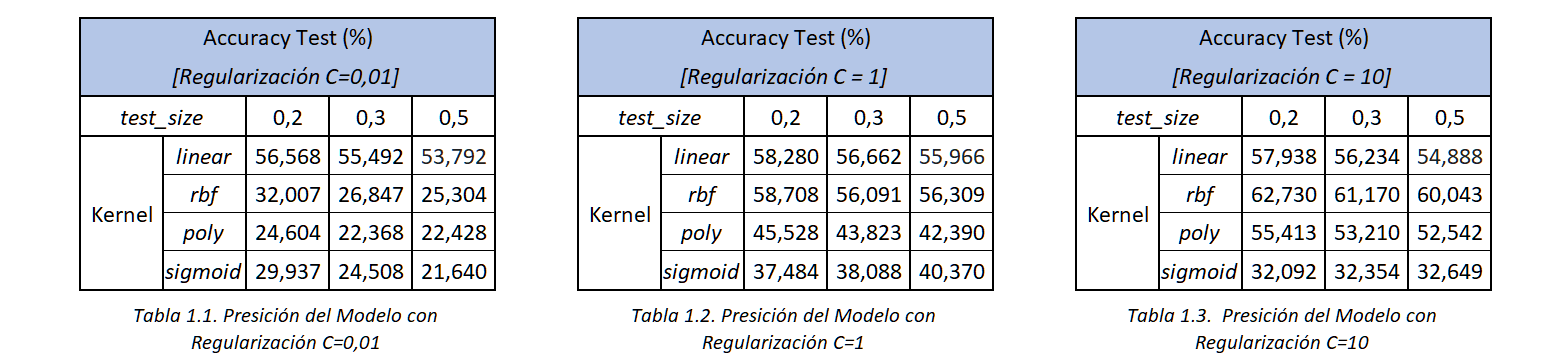


A continuación se aumentará el valor de la regularización, haciendo que el modelo con un kernel linear tarde en compilar. Debido a que el valor C es la penalización inversa del sistema, sí se aumenta éste genera un sobreajuste al modelo lo que a su vez dispara el tiempo de compilación.

Se omitirá entonces el kernel linear para las siguientes presiciones. 

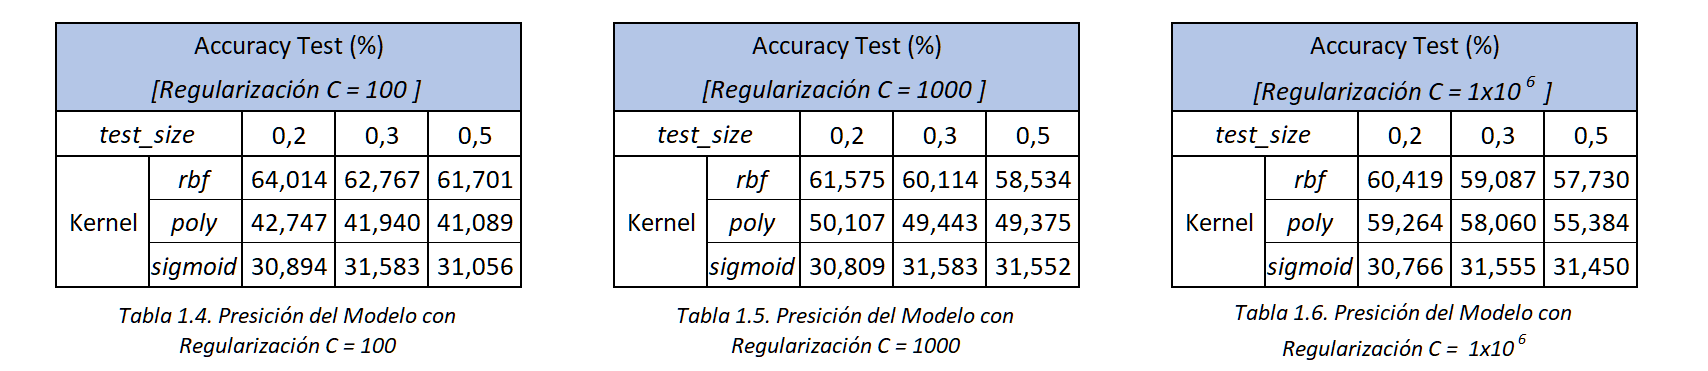

Observemos el comportamiento de la presición con diferentes grados para el kernel polinómico.

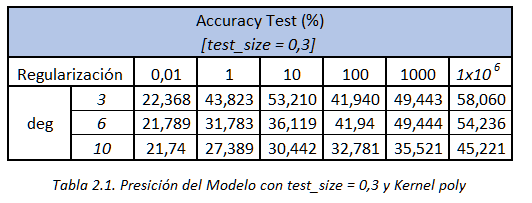

Continuando con la evaluación del desempeño del modelo según los resultados obtenidos del `accuracy_score`, tomaremos como valores estándar los hiperparametros `Kernel = rbf ` y `C =  100`, con un `test_size` de 0.3. Para esto nos aprovecharemos de la función de sklearn [`classification_report`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html).

`classification_report` provee un resumen de las principales métricas utilizadas en clasificación;

* `precision` = La precisión es capacidad del clasificador de no etiquetar como positiva una muestra que es negativa. Cuanto menor es la dispersión mayor la precisión. En nuestro modelo, la precisión es la dispersión del conjunto de valores obtenidos `yEst` a partir de mediciones repetidas del `y_test`. 
* `recall` = También conocido como la sensibilidad, es la proporción que obtiene el modelo al clasificar correctamente un valor positivo. Esta métrica indica la fracción de Etiquetas donde declaramos correctamente *x emoción* de todos los casos donde la emoción real es *x emoción*. 
* `f1-score` =  Resume la precisión y sensibilidad en una sola métrica y se entiende como la media entre ambas.
* `support` = Es el número de ocurrencias de cada clase en `y_train`

Se implementó de la forma
```
target_names = dfCaracteristicas['Etiquetas'].unique()
print("Evaluamos el comportamiento de la prediccion \n", classification_report(y_test, yEst, target_names=target_names))
```
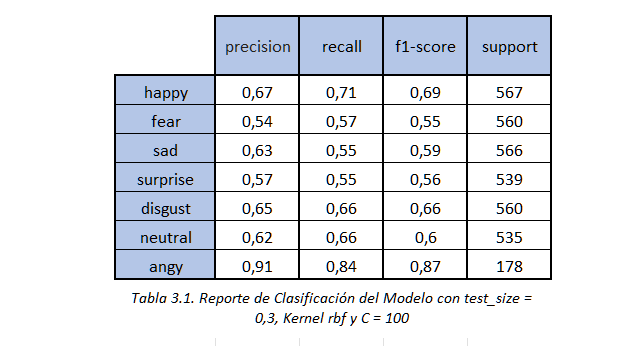

El `classification_report` también extrae unos valores promedio. La media macro, que se refiere al promedio no ponderado por etiqueta y la media ponderada, promedio ponderado por etiqueta. 

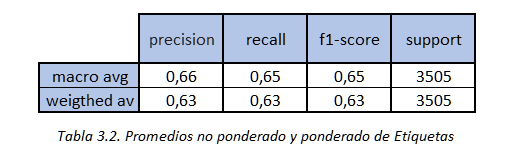






Nótese que, al tener una alta precisión y alto recall, el modelo escogido maneja de manera optima los features extraídos. Además, el kernel de función de base radial resulta óptimo para el proceso de clasificación de grandes números de datos, como lo es la base de datos empleada en el presente proyecto, debido a que almacena los vectores de soporte únicamente durante el entrenamiento y no todo el conjunto de datos acelerando el proceso de ejecución y aumentando porcentaje de precisión. Esto último corresponde a que nuestra base de datos es un conjunto no linealmente separable.
